## Identify Upside Down Downloaded Images and Flip w CNN 
### PROBLEM DEFINITION AND TASK EXPLANATION 

After downloading ~173,000 images, through manual inspection, it was noticed that a significant portion of images in the sampled batches were flipped upside down in the downloading process without any indicative meta-data. The presence of upside-down images fundamentally changes the operations and accuracy of further data augmentation, segmentation, and model training. Therefore, as an intermediary step, we will train a model to identify and correct upside-down images using a CNN. 

In [1]:
# just for personal reference to recall how many images have been downloaded 
n_ct = 346 
total_count = n_ct * 500 
print(total_count, "images downloaded")

173000 images downloaded


## Training model to build an upside-down recognizer 

Validating images in folder: /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201210600 copy/R
Validating images in folder: /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201210600 copy/W
Found 349 images belonging to 2 classes.
Found 75 images belonging to 2 classes.
Found 76 images belonging to 2 classes.
Epoch 1/10
11/11 [==============================] - 33s 3s/step - loss: 1.7198 - accuracy: 0.8883 - val_loss: 2.2528 - val_accuracy: 0.9733
Epoch 2/10
11/11 [==============================] - 26s 2s/step - loss: 1.3244 - accuracy: 0.9685 - val_loss: 2.2793 - val_accuracy: 0.9600
Epoch 3/10
11/11 [==============================] - 26s 2s/step - loss: 1.2691 - accuracy: 0.9656 - val_loss: 1.8803 - val_accuracy: 0.9867
Epoch 4/10
11/11 [==============================] - 27s 2s/step - loss: 0.4916 - accuracy: 0.9828 - val_loss: 1.0647 - val_accuracy: 0.9867
Epoch 5/10
11/11 [==============================] - 31s 3s/step - loss: 0.4478 - accuracy: 0.9799 - val_loss: 1.0616 - val_accuracy

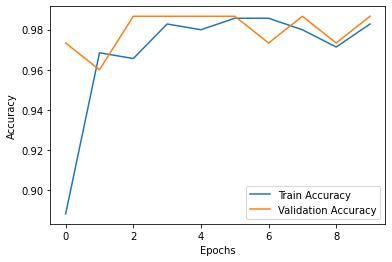

In [3]:
# import libraries for classification work 
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
from PIL import Image

# We begin by uploading paths for training of manually verified rightside up and upsidedown images. 
# Given the simplicity of the task we only use 500 images for both classifications  
dataset_path = "/Volumes/MRDALLMAYR/data/data_for_RWtraining" 
upright_folder = os.path.join(dataset_path, "R") # R standing for Right orientation 
upside_folder = os.path.join(dataset_path, "W") # W standing for Wrong orientation

# Next, we validate Images (sometimes they are corrupted in the downloading process from Mapillary)
def check_images(folder_path):
    print(f"Validating images in folder: {folder_path}")
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify if the file is an image
            except (IOError, SyntaxError) as e:
                print(f"Problem with file: {file_path} - {e}")
                os.remove(file_path)  # Remove problematic file

# Check Images 
check_images(upright_folder)
check_images(upside_folder)

# Create Split Directories for ML training, validation, testing
split_base_dir = "/Volumes/MRDALLMAYR/data/upsidedown_identification/split_dataset"
os.makedirs(split_base_dir, exist_ok=True)

train_dir = os.path.join(split_base_dir, "train")
val_dir = os.path.join(split_base_dir, "val")
test_dir = os.path.join(split_base_dir, "test")

for split in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(split, "upright"), exist_ok=True)
    os.makedirs(os.path.join(split, "upside_down"), exist_ok=True)

# Split Data into train, validation, and testing
def split_and_copy_images(src_folder, train_dest, val_dest, test_dest, label):
    all_images = list(Path(src_folder).glob("*.jpg"))  # Adjust extension if not .jpg
    train_imgs, temp_imgs = train_test_split(all_images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for img in train_imgs:
        shutil.copy(img, os.path.join(train_dest, label, img.name))
    for img in val_imgs:
        shutil.copy(img, os.path.join(val_dest, label, img.name))
    for img in test_imgs:
        shutil.copy(img, os.path.join(test_dest, label, img.name))

split_and_copy_images(upright_folder, train_dir, val_dir, test_dir, "upright")
split_and_copy_images(upside_folder, train_dir, val_dir, test_dir, "upside_down")

# For a more robust training dataset and less chance for overfitting the model, we perform data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0) # minimal data augmentation for the validation dataset 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False,
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False,
)

# Define model architecture from pretrained weights from image net 
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pre-trained layers

model = Sequential(
    [
        base_model,
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid"),  # Sigmoid used for binary classification of upright or upside down 
    ]
)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train model over 10 epochs 
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10, 
    verbose=1,
)

# Evaluate model performance by looking at the test set results 
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Make predictions for unseen data set 
predictions = (model.predict(test_generator) > 0.5).astype("int32")
true_labels = test_generator.classes

# Print out model results 
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys()))

print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predictions))

# Save the trained model for use in the larger dataset 
model.save("image_orientation_classifier.h5")
print("Model saved as image_orientation_classifier.h5")

# Define a function to classify just one image  
def classify_image(image_path, model):
    """
    Classify an image as either upside down or rightside up, using a trained CNN.
    """
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return "Upright" if prediction >= 0.5 else "Upside-Down"


# Example usage as a quick sanity check 
image_path = "/Users/etoileboots/Downloads/111334917688345.jpg" # upload an upside down image 
result = classify_image(image_path, model)
print(f"The image is classified as: {result}")

# Optional: Plot Training History
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Classify all images as rightside up and upside down 

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm
from pathlib import Path
import shutil

# Upload paths
dataset_path = "/Volumes/MRDALLMAYR/data/mapillary_images_osm"  
output_base_dir = "/Volumes/MRDALLMAYR/data/WR"
os.makedirs(output_base_dir, exist_ok=True) # make the output directory 
"""upright_dir = os.path.join(output_base_dir, "upright")
upside_down_dir = os.path.join(output_base_dir, "upside_down")
os.makedirs(upright_dir, exist_ok=True)
os.makedirs(upside_down_dir, exist_ok=True)"""

# Sequential log file
log_file = os.path.join(output_base_dir, "classification_results.csv")
if not os.path.exists(log_file):
    pd.DataFrame(columns=["image_path", "classification"]).to_csv(log_file, index=False)

model_path = "image_orientation_classifier.h5" # Upload the model just trained in the code-cell above 
model = load_model(model_path)

# Read already processed images from the log file to avoid reprocessing
processed_images = set(pd.read_csv(log_file)["image_path"].tolist())

# Iterate over dataset and classify images
for root, _, files in tqdm(os.walk(dataset_path), desc="Processing images"):
    for file in files:
        if file.endswith((".jpg", ".png", ".jpeg")):  # Process only image files
            image_path = os.path.join(root, file)
            if image_path in processed_images:
                continue  # Skip already processed images
            try:
                # Classify the image
                classification = classify_image(image_path, model)
                # Append results to the log file
                with open(log_file, "a") as f:
                    f.write(f"{image_path},{classification}\n")
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

print(f"Classification completed. Results are being logged in {log_file}")


Processing images: 11it [00:00, 52.88it/s]

Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201100001/._218894029681896.jpg: cannot identify image file <_io.BytesIO object at 0x7fc894861040>
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201100001/856695231725127.jpg: image file is truncated (6 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201100001/._854445205503361.jpg: cannot identify image file <_io.BytesIO object at 0x7fc8448b97c0>
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201100001/._814251032801298.jpg: cannot identify image file <_io.BytesIO object at 0x7fc8448b97c0>
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201100001/._936496570507950.jpg: cannot identify image file <_io.BytesIO object at 0x7fc8448b97c0>
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201100001/._898047041041512.jpg: cannot identify image file <_io.BytesIO object at 0x7fc8448b97c0>
Error processing /Volumes/MRDALLMAYR

Processing images: 75it [00:01, 68.50it/s]

Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201312601/._136156151870630.jpg: cannot identify image file <_io.BytesIO object at 0x7fc835aa88b0>


Processing images: 99it [00:01, 63.29it/s]

Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201320500/502787957506697.jpg: image file is truncated (6 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201320602/2531368963826239.jpg: image file is truncated (4 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201320602/1107916879704099.jpg: image file is truncated (3 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201320700/837669083774525.jpg: image file is truncated (2 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201321002/2887301444881727.jpg: image file is truncated (0 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201321102/2954603541419506.jpg: image file is truncated (6 bytes not processed)


Processing images: 165it [00:02, 60.07it/s]

Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201350104/2807435189516863.jpg: image file is truncated (0 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201350201/158765562918587.jpg: image file is truncated (2 bytes not processed)


Processing images: 198it [00:03, 58.25it/s]

Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201411503/485630402660130.jpg: image file is truncated (4 bytes not processed)


Processing images: 273it [00:04, 45.10it/s]

Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201511100/1442047900010672.jpg: image file is truncated (4 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201511301/432760625804347.jpg: image file is truncated (3 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201511301/3759493590995083.jpg: image file is truncated (3 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201511301/930312637757573.jpg: image file is truncated (0 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201520100/2579229062238335.jpg: image file is truncated (2 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201520501/._2892080977701834.jpg: cannot identify image file <_io.BytesIO object at 0x7fc814f13900>


Processing images: 278it [00:04, 39.16it/s]

Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201520502/276781587510231.jpg: image file is truncated (6 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201520502/613194649637423.jpg: image file is truncated (6 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201520502/932605984242457.jpg: image file is truncated (6 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201520601/304279261373271.jpg: image file is truncated (12 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201520601/268398008319751.jpg: broken data stream when reading image file
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201520603/2939919749614775.jpg: image file is truncated (6 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201520603/300231011645556.jpg: image file is truncated (5 bytes not proces

Processing images: 283it [00:04, 31.39it/s]

Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201520604/219965272889147.jpg: broken data stream when reading image file
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201520700/1764138090443205.jpg: broken data stream when reading image file
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201520700/832971707302185.jpg: image file is truncated (2 bytes not processed)
Error processing /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201520700/3161717610818468.jpg: broken data stream when reading image file


Processing images: 347it [00:06, 57.78it/s]

Classification completed. Results are being logged in /Volumes/MRDALLMAYR/data/WR/classification_results.csv


## Flip all images labelled as upside-down 

In [7]:
# Import libraries 
import pandas as pd
from PIL import Image

# Path to the CSV file containing classification results and read. 
csv_path = "/Volumes/MRDALLMAYR/data/WR/classification_results.csv"  
data = pd.read_csv(csv_path, header=None, names=["image_path", "orientation"])

# Calculate percentages of upside down and rightside up 
total_images = len(data)
upright_count = len(data[data["orientation"] == "upright"])
upside_down_count = len(data[data["orientation"] == "upside_down"])

upright_percentage = (upright_count / total_images) * 100
upside_down_percentage = (upside_down_count / total_images) * 100

print(f"Total Images: {total_images}")
print(f"Upright Images: {upright_count} ({upright_percentage:.2f}%)")
print(f"Upside Down Images: {upside_down_count} ({upside_down_percentage:.2f}%)")

# Flip upside-down images
for _, row in data.iterrows():
    image_path = row["image_path"]
    orientation = row["orientation"]
    
    if orientation == "upside_down":
        try:
            img = Image.open(image_path) # Open the image
            flipped_img = img.rotate(180) # Flip the image
            flipped_img.save(image_path) # Overwrite the image in the same location
            print(f"Flipped and overwritten: {image_path}")
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

print("Processing complete.")

Total Images: 172812
Upright Images: 163651 (94.70%)
Upside Down Images: 9160 (5.30%)
Flipped and overwritten: /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201100001/377310333637159.jpg
Flipped and overwritten: /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201100001/987717731970455.jpg
Flipped and overwritten: /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201100001/1182666792157685.jpg
Flipped and overwritten: /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201100001/258183619439720.jpg
Flipped and overwritten: /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201100001/181849420484158.jpg
Flipped and overwritten: /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201100001/512498019878847.jpg
Flipped and overwritten: /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201100001/927034921425635.jpg
Flipped and overwritten: /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201100001/848756675725851.jpg
Flipped and overwritten: /Volumes/MRDALLMAYR/data/mapillary_images_osm/48201100001/259704